In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
def BS_call_price_delta(sigma, S, K, r, T, t, Greek):
    
    if Greek == 'Price' and T > 0: # Pris for en call option
        d1 = np.multiply(1. / (sigma*np.sqrt((T-t))),(np.log(S/K) + (r + sigma**2 / 2.) * (T-t)))
        d2 = d1 - sigma * np.sqrt((T-t))
        result = np.multiply(norm.cdf(d1),S) - np.multiply(norm.cdf(d2) * K, np.exp(-r * (T-t)))
        
    if Greek == 'Price' and T == 0:
        result = max(S-K,0)
    
    if Greek == "Delta" and T > 0: # dC/dS = Delta - Hvor meget vi skal købe/sælge af det underliggende aktiv
        d1 = np.multiply(1. / (sigma*np.sqrt((T-t))),(np.log(S/K) + (r + sigma**2 / 2.) * (T-t)))
        result = norm.cdf(d1)
        
    
    if Greek == 'Delta' and T == 0:
        result = 0
    
    return result

In [3]:
### Parameter ###
S_0 = 100.0 
T = 1
t = 0 
K = 110
r = 0.02
mu = 0.1   
# Trend/drift i markedet. 
# Lav mu -> kursen konvergere mod sit naturlige niveau (nuværende værdi) = mean reversion, eks. råstoffer.
# Høj mu -> kursen bevæger sig mod en nyt niveau, følger enten høj/positiv eller lav/negativ trend/udvikling.
antal_hedge = np.linspace(0,252,44)
sigma = 0.2 # volatilitet
Npaths = 10000 # Antal simuleringer

In [4]:
# Results
S_t = [0.0] * Npaths
Option_Payoff = [0.0] * Npaths
Hedge_Payoff = [0.0] * Npaths
Error = [0.0] * Npaths

np.random.seed(12345)

In [5]:
list_of_data = []
list_of_Error = []
### Simulation Engine ###
# Loop over Antal hedge
for Nhedgepoints in antal_hedge[1:]:
    hedge = int(Nhedgepoints)
    dt = (T-t)/Nhedgepoints
    print(hedge)
    # Loop over Npaths
    for j in range(0, Npaths):
        S = S_0
   
        # DeltaHedge
        V = BS_call_price_delta(sigma, S, K, r, T, t, "Price") # Start investering i call-option: Pris på call-option
        a = BS_call_price_delta(sigma, S, K, r, T, t, "Delta") # Investering i underliggende aktiv <- delta
        b = V-a*S # Resten af sine penge i banken, self-fin. Cond. 
        # Loop over Nhedgepoints
        for i in range(0, hedge+1):
            eps = np.random.normal(0, 1) # Normeps=random.normal() simulate outcome of N(0,1)
            S = S*np.exp((mu-sigma**2/2)*dt+sigma*np.sqrt(dt)*eps)
            # Delta-Hedge
            V = a*S+b*np.exp(r*dt) # Værdien af ens portefølje på nuværende tidspunkt: underliggende aktiv + penge i banken
            a = BS_call_price_delta(sigma, S, K, r, T-i*dt, t, "Delta") # Finder delta for det nuværende tidspunkt
            b = V-a*S # Hvor mange penge vi har i banken til nuværende tidspunkt
   
        S_t[j] = S # Samler alle aktiekurser til udløb
        Hedge_Payoff[j] = V # Samler alle værdier af porteføljer til udløb
        Option_Payoff[j] = BS_call_price_delta(sigma, S, K, r, 0, 0, "Price") # Samler payoff på alle call option

    # Calc Error
    list_of_data.append(S_t[:])
    list_of_data.append(Hedge_Payoff[:])
    list_of_data.append(Option_Payoff[:])
    Error = np.array(Hedge_Payoff) - np.array(Option_Payoff)
    list_of_Error.append(Error)

5
11
17
23
29
35
41
46
52
58
64
70
76
82
87
93
99
105
111
117
123
128
134
140
146
152
158
164
169
175
181
187
193
199
205
210
216
222
228
234
240
246
252


In [6]:
df = pd.DataFrame(data=list_of_Error)
df1 = df.to_numpy()

In [7]:
x = antal_hedge[1:]
y = [np.std(e) for e in df1]
xmax = x.max()
xmin = x.min()


X_Y_Spline = make_interp_spline(x, y)

X_ = np.linspace(xmin, xmax, 10000)
Y_ = X_Y_Spline(X_)

(0.0, 3.5)

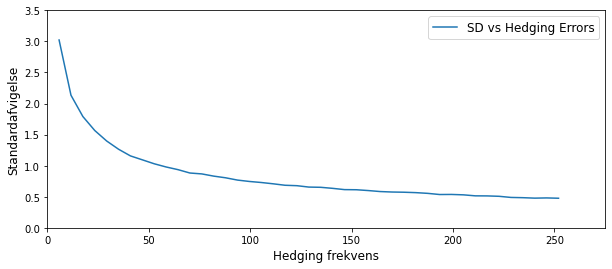

In [8]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(antal_hedge[1:],[np.std(e) for e in df.to_numpy()],label='SD vs Hedging Errors')
ax.set_xlabel('Hedging frekvens', fontsize=12)
ax.set_ylabel('Standardafvigelse', fontsize=12)
ax.legend(fontsize=12);
ax.set_xlim([0, 275])
ax.set_ylim([0, 3.5])

<ipython-input-9-90ca4c201776>:8: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim([0,300])
<ipython-input-9-90ca4c201776>:9: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim([0,4])


(0.43379202027196206, 4)

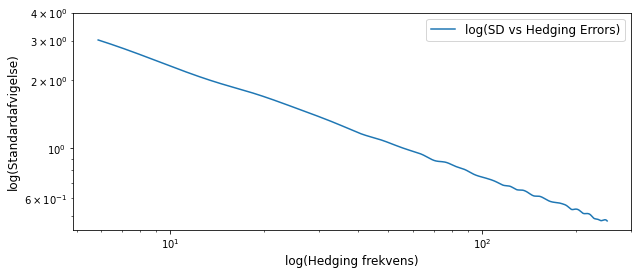

In [9]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(X_, Y_,label='log(SD vs Hedging Errors)')
ax.set_xlabel('log(Hedging frekvens)', fontsize=12)
ax.set_ylabel('log(Standardafvigelse)', fontsize=12)
plt.yscale('log')
plt.xscale('log')
ax.legend(fontsize=12);
ax.set_xlim([0,300])
ax.set_ylim([0,4])

In [10]:
new_Y = np.log(Y_)

In [11]:
new_x = np.log(X_)

In [12]:
new_X = new_x.reshape((-1, 1))

In [13]:
model = LinearRegression().fit(new_X,new_Y)

In [14]:
print(f"slope: {model.coef_}")

slope: [-0.49659923]
